In [ ]:
!apt install swig
!pip install gymnasium
!pip install gymnasium[box2d]

Episode 1: 286.07377657208673
Episode 2: 353.02821786664555
Episode 3: 309.04095119077203
Episode 4: 386.6400016305982
Episode 5: 316.7080425899238
Episode 6: 289.79599879418777
Episode 7: 390.5801344432246
Episode 8: 375.17645924925307
Episode 9: 352.36671922549317
Episode 10: 405.94363225471676
Episode 11: 399.4330054689803
Episode 12: 250.38372589222192
Episode 13: 428.56088403784173
Episode 14: 239.64179532022564
Episode 15: 379.61824127282284
Episode 16: 400.9410376072224
Episode 17: 322.0944756470151
Episode 18: 357.154164042474
Episode 19: 325.78579702346553
Episode 20: 334.5049356863946
Episode 21: 377.82618554079073
Episode 22: 358.4295598897223
Episode 23: 353.3667214415144
Episode 24: 342.1768614709278
Episode 25: 349.6311199183672
Episode 26: 374.1453333644008
Episode 27: 379.4721958929441
Episode 28: 341.64867634851936
Episode 29: 67.77294910105749
Episode 30: 377.18174892979437
Episode 31: 280.66787890414616
Episode 32: 261.7988409927514
Episode 33: 381.8211150999322
Epis

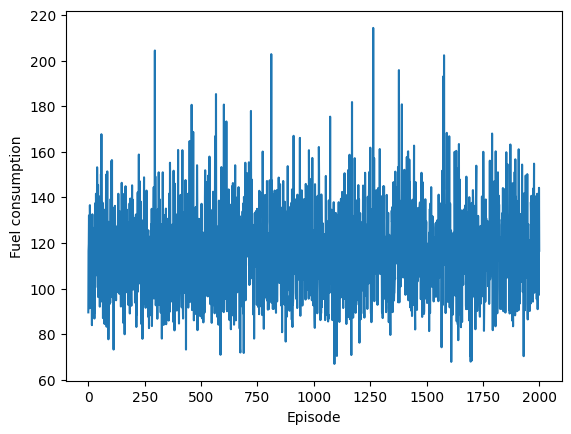

In [ ]:
import gymnasium as gym
import random
import numpy as np

from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt


def moving_average(data, window):
    series = pd.Series(data)
    return series.rolling(window).mean()


def plot_rewards(values, path):
    plt.figure(2)
    plt.clf()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    plt.plot(moving_average(values, 100))
    plt.savefig(path)


def plot_epsilon(values, path):
    plt.figure(2)
    plt.clf()
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(values)
    plt.savefig(path)


def plot_steps_per_episode(values, path):
    plt.figure(2)
    plt.clf()
    plt.xlabel('Episode')
    plt.ylabel('Steps per episode')
    plt.plot(values)
    plt.savefig(path)


def plot_fuel_consumption(values, path):
    plt.figure(2)
    plt.clf()
    plt.xlabel('Episode')
    plt.ylabel('Fuel consumption')
    plt.plot(values)
    plt.savefig(path)


def plot_data():
    with open("rewards.txt", "r") as f:
        lines = f.readlines()
        rewards = [float(line.strip()) for line in lines]
        plot_rewards(rewards, "rewards.png")

    with open("epsilons.txt", "r") as f:
        lines = f.readlines()
        epsilons = [float(line.strip()) for line in lines]
        plot_epsilon(epsilons, "epsilons.png")

    with open("steps_per_episode.txt", "r") as f:
        lines = f.readlines()
        steps_per_episode = [float(line.strip()) for line in lines]
        plot_steps_per_episode(steps_per_episode, "steps_per_episode.png")

    with open("fuel_consumption.txt", "r") as f:
        lines = f.readlines()
        fuel_consumption = [float(line.strip()) for line in lines]
        plot_fuel_consumption(fuel_consumption, "fuel_consumption.png")


def plot_eval_data():
    with open("rewards.txt", "r") as f:
        lines = f.readlines()
        rewards = [float(line.strip()) for line in lines]
        plot_rewards(rewards, "rewards.png")

    with open("steps_per_episode.txt", "r") as f:
        lines = f.readlines()
        steps_per_episode = [float(line.strip()) for line in lines]
        plot_steps_per_episode(steps_per_episode, "steps_per_episode.png")

    with open("fuel_consumption.txt", "r") as f:
        lines = f.readlines()
        fuel_consumption = [float(line.strip()) for line in lines]
        plot_fuel_consumption(fuel_consumption, "fuel_consumption.png")


parameters = {
    "episodes": 1000,
    "max_steps": 1000,
    "epsilon": 1,
    "epsilon_decay": 0.99,
    "epsilon_min": 0.01,
    "update_freq": 4,
    "gamma": 0.999,
    "seed": 12,
    "lr": 0.0005,
    "tau": 0.001,
    "buffer_size": 100_000,
    "batch_size": 64,
    "reward_target_mean": 2000,
    "render": False
}

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        random.seed(parameters["seed"])

    def save(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    """Deep Q Network."""

    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(parameters["seed"])

        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)


class Agent():

    def __init__(self, env_name):
        if parameters["render"]:
            self.env = gym.make(env_name, render_mode="human")
        else:
            self.env = gym.make(env_name)
        random.seed(parameters["seed"])
        state_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n

        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)

        # self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=parameters["lr"])
        # or self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(parameters["buffer_size"])
        self.steps = 0

    def act(self, state, epsilon):

        state = torch.from_numpy(state).float().unsqueeze(0)
        self.policy_net.eval()
        self.policy_net.train()

        # epsilon-greedy
        if random.random() > epsilon:
            with torch.no_grad():
                # return self.policy_net(state).max(1)[1].view(1, 1)
                return np.argmax(self.policy_net(state).cpu().data.numpy())
        else:
            return self.env.action_space.sample()

    def learn(self, transitions, gamma):
        batch = Transition(*zip(*transitions))
        state_batch = torch.from_numpy(
            np.vstack([x for x in batch.state if x is not None])).float()
        action_batch = torch.from_numpy(
            np.vstack([x for x in batch.action if x is not None])).long()
        reward_batch = torch.from_numpy(
            np.vstack([x for x in batch.reward if x is not None])).float()
        next_state_batch = torch.from_numpy(
            np.vstack([x for x in batch.next_state if x is not None])).float()
        done_batch = torch.from_numpy(np.vstack(
            [x for x in batch.done if x is not None]).astype(np.uint8)).float()

        Q_argmax = self.policy_net(next_state_batch).detach()
        _, a_max = Q_argmax.max(1)

        Q_target_next = self.target_net(
            next_state_batch).detach().gather(1, a_max.unsqueeze(1))

        Q_target = reward_batch + \
                   (gamma * Q_target_next * (1 - done_batch))

        Q_expected = self.policy_net(state_batch).gather(1, action_batch)

        # loss = F.mse_loss(Q_expected, Q_target)

        # or use Huber loss
        loss = F.smooth_l1_loss(Q_expected, Q_target)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(
                parameters["tau"] * policy_param.data + (1. - parameters["tau"]) * target_param.data)

    def train(self):
        reward_history = []
        steps_per_episode = []
        epsilons = []
        fuel_consumption = []
        rolling_reward_history = deque(maxlen=100)
        epsilon = parameters["epsilon"]
        for i_episode in range(parameters["episodes"]):
            state = self.env.reset()[0]
            reward, fuel = 0, 0
            steps = parameters["max_steps"]
            for t in range(parameters["max_steps"]):
                action = self.act(state, epsilon)
                if action == 2:
                    fuel += 1
                elif action != 0:
                    fuel += 0.1
                next_state, r, done, _, _ = self.env.step(action)
                self.memory.save(state, action, next_state, r, done)

                self.steps = (self.steps + 1) % parameters["update_freq"]
                if self.steps == 0:
                    if len(self.memory) >= parameters["batch_size"]:
                        transitions = self.memory.sample(parameters["batch_size"])
                        self.learn(transitions, parameters["gamma"])
                state = next_state
                reward += r
                if done:
                    steps = t
                    break

            reward_history.append(reward)
            steps_per_episode.append(steps)
            rolling_reward_history.append(reward)
            epsilons.append(epsilon)
            fuel_consumption.append(fuel)
            epsilon = max(parameters["epsilon_decay"] * epsilon, parameters["epsilon_min"])

            print('\rEpisode {}\tAverage Reward: {:.2f}'.format(
                i_episode + 1, np.mean(rolling_reward_history)), end="")
            if (i_episode + 1) % 100 == 0:
                print('\rEpisode {}\tAverage Reward: {:.2f}'.format(
                    i_episode + 1, np.mean(rolling_reward_history)))
                torch.save(self.policy_net.state_dict(), 'model.pth')
            if np.mean(rolling_reward_history) >= parameters["reward_target_mean"]:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                    i_episode + 1 - 100, np.mean(rolling_reward_history)))
                torch.save(self.policy_net.state_dict(), 'model.pth')
                break

        with open("rewards.txt", "w") as f:
            for elem in reward_history:
                f.write(str(elem) + '\n')
        with open("epsilons.txt", "w") as f:
            for elem in epsilons:
                f.write(str(elem) + '\n')
        with open("steps_per_episode.txt", "w") as f:
            for elem in steps_per_episode:
                f.write(str(elem) + '\n')
        with open("fuel_consumption.txt", "w") as f:
            for elem in fuel_consumption:
                f.write(str(elem) + '\n')

    def test(self):
        self.policy_net.load_state_dict(torch.load(
            'model.pth', map_location=lambda storage, loc: storage))

        test_scores = []
        steps_per_episode = []
        fuel_consumption = []
        for j in range(2000):
            state = self.env.reset()[0]
            reward, fuel = 0, 0
            steps = parameters["max_steps"]
            for k in range(parameters["max_steps"]):
                action = self.act(state, epsilon=0)
                if action == 2:
                    fuel += 1
                elif action != 0:
                    fuel += 0.1
                state, r, done, _, _ = self.env.step(action)
                reward += r
                if done:
                    steps = k
                    break

            print('Episode {}: {}'.format(j + 1, reward))
            test_scores.append(reward)
            steps_per_episode.append(steps)
            fuel_consumption.append(fuel)

        avg_score = sum(test_scores) / len(test_scores)

        print('\rAverage reward: {:.2f}'.format(avg_score))

        with open("rewards.txt", "w") as f:
            for elem in test_scores:
                f.write(str(elem) + '\n')
        with open("steps_per_episode.txt", "w") as f:
            for elem in steps_per_episode:
                f.write(str(elem) + '\n')
        with open("fuel_consumption.txt", "w") as f:
            for elem in fuel_consumption:
                f.write(str(elem) + '\n')


if __name__ == '__main__':
    agent = Agent('RewardCustomLunarLander')
    # agent.train()
    # plot_data()
    agent.test()
    plot_eval_data()
